In [1]:
# Workspace problem with several narrow gaps

import torch
import torch.nn as nn

from functools import partial
import numpy as np
from numpy.random import default_rng
from io import StringIO
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.animation as animation
import sys
import time
import cv2
from celluloid import Camera
from IPython.display import HTML

sys.path.append('/home/oscar_palfelt/MSc_thesis/ompl/py-bindings')
from ompl import base as ob
from ompl import control as oc
from ompl import geometric as og

rng = default_rng(900)

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")

In [2]:
# load map file

filename = '/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/motion_planning/maps/mapA.png'
mapImg = cv2.imread(filename, 0)
blurImg = cv2.blur(mapImg, ksize=(3,3))
occGrid = np.clip(mapImg, 0, 1)
inflatedGrid = np.floor(blurImg / 255)

assert occGrid.shape[0] == occGrid.shape[1]
gridSize = occGrid.shape[0]

In [3]:
# neural network parameters
mb_size = 256 # mini batch dim
h_Q_dim = 512*4 # encoder dim
h_P_dim = 512*4 # decoder dim

# problem dimenc_dimsions
nDrawnSamples = 24 # number of dependent samples to draw during smapling (length of predicted control series)
nPreviousStates = 1 # number of previous states to condition on the steering prediction
dim = 4 # (x, y, yaw, steer)
dataElements = (nDrawnSamples + nPreviousStates) * dim + dim - 1

z_dim = 1 # latent dim
X_dim = nDrawnSamples*dim # steering
y_dim = dim # renp.piruction of the original point (unsused?)
c_dim = dataElements - X_dim # dimension of conditioning variable

In [4]:
# define pytorch networks
# based on https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/.ipynb_checkpoints/01_Variational_AutoEncoder-checkpoint.ipynb

class Encoder(nn.Module):
    
    def __init__(self, input_dim=X_dim+c_dim, hidden_dim=h_Q_dim, latent_dim=z_dim):
        super(Encoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.z_mu = nn.Linear(hidden_dim, latent_dim)
        self.z_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):

        seq = self.network(x)

        return self.z_mu(seq), self.z_logvar(seq)


class Decoder(nn.Module):
    def __init__(self, latent_dim=z_dim+c_dim, hidden_dim=h_P_dim, output_dim=X_dim):
        super(Decoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        
        return self.network(x)


class NeuralNetwork(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(NeuralNetwork, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(mean).to(DEVICE)        # sampling epsilon        
        z = mean + torch.exp(0.5 * logvar) * epsilon       # reparameterization trick
        return z

    def forward(self, x, c, encode=True):
        if encode:
            z_mu, z_logvar = self.Encoder(torch.cat((x, c), dim=1))
            z = self.reparameterization(z_mu, z_logvar)

            y = self.Decoder(torch.cat((z, c), dim=1))
            
            return y, z_mu, z_logvar
        else:
            z = x
            y = self.Decoder(torch.cat((z, c), dim=1))    

            return y

network = torch.load('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/networks/diff_24.pt', map_location=torch.device(DEVICE))

In [5]:
# read in data from .txt file, re-arrange to allow drawing multiple depedent samples

filename = '/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/motion_planning/data/mapA_data_53kPlans'
rawdata = np.genfromtxt(filename, delimiter=',', dtype='d', usecols=[0,1,2,3,7,8,9]) # disregard init

_, pathsIdx = np.unique(rawdata[:,4:], axis=0, return_index=True)
pathsIdx.sort()

pathsLengths = np.roll(pathsIdx, -1) - pathsIdx
pathsLengths[-1] = rawdata.shape[0] - np.sum(pathsLengths[:-1])

validLengthsIdx = np.argwhere(pathsLengths >= nPreviousStates + nDrawnSamples) 
validPlansIdx = pathsIdx[validLengthsIdx]

data = np.zeros(shape=(1, dataElements)) # steering angles, samples (x,y,yaw), goal(x,y,yaw)
tempdata = np.copy(data) # steering angles, samples (x,y,yaw), goal(x,y,yaw)
for ci, i in enumerate(validPlansIdx.reshape(-1)):
    for j in range(pathsLengths[ci] - (nPreviousStates + nDrawnSamples - 1)):
        sample = np.arange(start=j, stop=j + nPreviousStates + nDrawnSamples)

        if np.any(np.abs(np.diff(rawdata[i + sample, 0])) > 0.05) or np.any(np.abs(np.diff(rawdata[i + sample, 1])) > 0.05):
            break # ignore duplicate plans (data generation is not perfect)

        tempdata = np.vstack((tempdata, np.append(rawdata[i + sample, :dim].reshape(1, (nPreviousStates + nDrawnSamples)*dim), rawdata[i, dim:].reshape(1, dim-1), axis=1))) 
        if ci % 500 == 0:
            data = np.vstack((data, tempdata[1:]))
            tempdata = np.zeros(shape=(1, dataElements))

rng.shuffle(data) # shuffle data

numEntries = data.shape[0]
print(data.shape)

(82251, 103)


In [6]:
# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)

ratioTestTrain = 0.8;
numTrain = int(numEntries*ratioTestTrain)

X_train = data[0:numTrain, dim * nPreviousStates:-dim+1:] # states [x,y,yaw,steer] to predict
X_test = data[numTrain:numEntries, dim * nPreviousStates:-dim+1:]

numTest = X_test.shape[0]

print(X_train.shape)

(65800, 96)


In [7]:
# generate conditioning variable

prevStates = data[:, :nPreviousStates*dim]
nextStates = data[:, nPreviousStates*dim:-dim+1]
nextStates = data[:, nPreviousStates*dim:-dim+1]
goalState = data[:, -dim+1:]

prevStatesConditions = data[:, :nPreviousStates * dim]
goalStateCondition = data[:, -dim+1:]

cs = np.concatenate((prevStatesConditions, goalStateCondition), axis=1)

c_dim = cs.shape[1]
c_train = cs[0:numTrain,:]  
c_test = cs[numTrain:numEntries,:]

print(cs.shape)

(82251, 7)


In [8]:
# define planning problem

def getThresholdPathLengthObj(si):
     obj = ob.PathLengthOptimizationObjective(si)
     obj.setCostThreshold(ob.Cost(4.0))
     return obj


def isRV2StateValid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied

    u = int(np.floor(state[0] * gridSize)) # right pointing image axis
    v = int(np.floor(gridSize * (1 - state[1]))) # down pointing image axis

    if spaceInformation.satisfiesBounds(state):
        return occGrid[v,u] > 0


def problemDef():

    # construct the state space we are planning in
    space = ob.RealVectorStateSpace(2)

    # set the bounds for the R^2 part of SE(2)
    bounds = ob.RealVectorBounds(2)
    bounds.setLow(0.001)
    bounds.setHigh(0.999)
    space.setBounds(bounds)

    # define a simple setup class
    ss = og.SimpleSetup(space)
    si = ss.getSpaceInformation()
    planner = og.RRTstar(si)

    ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
        partial(isRV2StateValid, ss.getSpaceInformation())))

    ss.setPlanner(planner)
    ss.getProblemDefinition().setOptimizationObjective(getThresholdPathLengthObj(si))
    
    return ss


def plan(planObj, initState, goalState):
 
    space = ob.RealVectorStateSpace(2)

    start = ob.State(space)
    start[0] = initState[0]
    start[1] = initState[1]

    goal = ob.State(space)
    goal[0] = goalState[0]
    goal[1] = goalState[1]

    planObj.setStartAndGoalStates(start, goal, 0.02)

    timeTerminationCondition = ob.timedPlannerTerminationCondition(2.)

    costTerminationCondition = ob.CostConvergenceTerminationCondition(planObj.getProblemDefinition(), solutionsWindow=4, epsilon=1.0)

    solved = planObj.solve(ob.plannerOrTerminationCondition(costTerminationCondition, timeTerminationCondition))

    if solved:
        planObj.simplifySolution()

In [9]:
class VehicleState():
    def __init__(self):
        self.x = 0
        self.y = 0
        self.yaw = 0
        self.v = 0

Debug:   RRTstar: Planner range detected to be 0.282277
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.40 in 279 iterations (157 vertices in the graph)
Info:    RRTstar: Created 156 new states. Checked 12246 rewire options. 1 goal states in tree. Final solution cost 1.396
Info:    Solution found in 0.052852 seconds
Debug:   The solution path was slightly touching on an invalid region of the state space, but it was successfully fixed.
Info:    SimpleSetup: Path simplification took 0.005423 seconds and changed from 8 to 7 states
saving animation


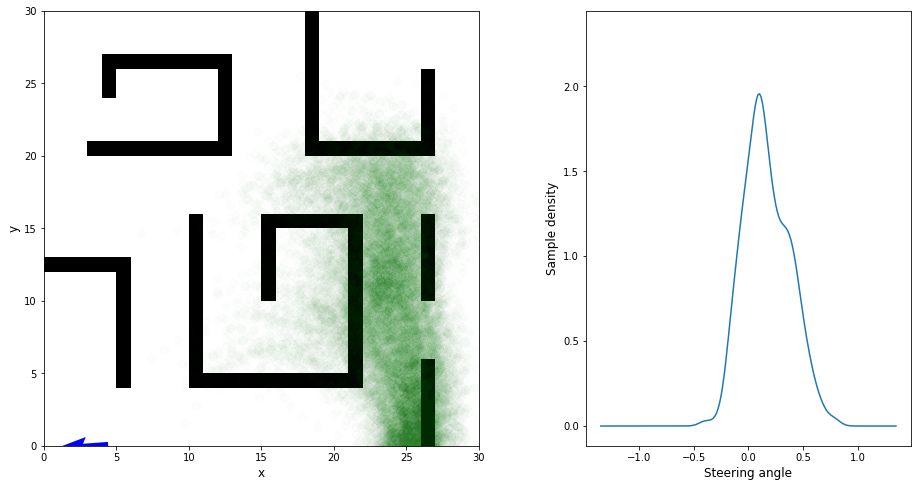

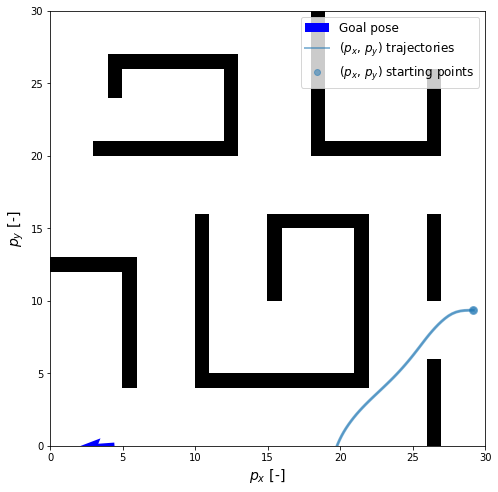

In [16]:
# Use random start states

# generate planning scenario, plan, and perform path following

minDistThreshold = 0.7 # minimum distance threshold betwen start/goal
nLatSamples = 800 # number of samples to draw in latent space (when using nn)
nCtrlIter = 80
nPredictCtrlSteps = 1 # number of steps to simulate the car for using a single prediction

dt = 0.1 # time step
L = 0.2 # vehicle length constant
v =  0.1 # vehicle speed

pathIdx = np.random.randint(numTrain, numEntries - 1)
goal = data[pathIdx, -dim+1:]

maxSteer = np.max(data[:, 3::dim])
minSteer = np.min(data[:, 3::dim])
steerAngles = np.linspace(minSteer, maxSteer, num=200)

nStarts = 1 # number of random initial conditions
statearr = np.zeros(shape=(nCtrlIter + 1, dim, nStarts))

animate = True
for i in range(nStarts):
    # --- choose random initial state ---
    pdef = problemDef()

    while True:
        
        while True: # randomize starting coordinates
            start = np.array([np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=0.001, high=0.999), 0])
            
            uStart = int(np.floor(start[0] * gridSize)) # right pointing image axis
            vStart = int(np.floor(gridSize * (1 - start[1]))) # down pointing image axis
            if np.abs(start[:2] - goal[:2]).sum() > minDistThreshold and inflatedGrid[vStart,uStart] > 0:
                break

        pdef.clear()
        plan(pdef, initState=start, goalState=goal)
        if pdef.getProblemDefinition().hasExactSolution():
            break

    ssol = np.loadtxt(StringIO(pdef.getProblemDefinition().getSolutionPath().printAsMatrix()))

    # remove points unneccesarily close to start/goal
    ssol = ssol[1:] if np.linalg.norm(ssol[0, :2] - start[:2]) < 0.02 else ssol
    ssol = ssol[:-1] if np.linalg.norm(ssol[-1, :2] - goal[:2]) < 0.02 else ssol

    if ssol.shape[0] > 0:
        # find suitable starting yaw 
        start_dxdy = ssol[0, :2] - start[:2]
        start_xydot = start_dxdy / np.linalg.norm(start_dxdy)
        start[-1] = np.sign(int(start_xydot[-1] > 0) - 0.5) * np.arccos(np.dot(start_xydot / np.linalg.norm(start_xydot), [1, 0])) # get yaw from xdot, ydot
    else:
        continue
    # ----------------------------------------

    state = VehicleState()

    state.x = start[0]; state.y = start[1]; state.yaw = start[2]; state.v = v

    statearr[0, :, i] = np.array([state.x, state.y, state.yaw, 0])

    if animate:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8), gridspec_kw={'width_ratios': [3, 2]})
        camera = Camera(fig)

    nStepsFromPrediction = 0 # number of steps taken so far given last CVAE prediction
    for ctrlIter in range(nCtrlIter):
        currentState = statearr[ctrlIter, :, i]

        if nStepsFromPrediction % nPredictCtrlSteps == 0:
            nStepsFromPrediction = 0 # number of steps taken so far given last CVAE prediction

            c = torch.from_numpy(np.repeat([np.append(currentState, goal)], nLatSamples, axis=0)).float().to(DEVICE)
            predictedStates = network(torch.randn(nLatSamples, z_dim).to(DEVICE), c, encode=False).cpu().detach().numpy()

            kdes = np.array([gaussian_kde(predictedStates[:, i * dim - 1]) for i in range(1, nPredictCtrlSteps + 1)])

        delta = steerAngles[np.argmax(kdes[nStepsFromPrediction].pdf(steerAngles))]

        if animate:
            ax1.scatter(predictedStates[:,::dim] * gridSize, predictedStates[:,1::dim] * gridSize, color='green', s=70, alpha=0.01) # nn samples
            ax1.quiver(currentState[0] * gridSize, currentState[1] * gridSize, np.cos(currentState[2]), np.sin(currentState[2]), color='red', scale=8.0, width=0.015)
            ax1.quiver(goal[0] * gridSize, goal[1] * gridSize, np. cos(goal[2]), np.sin(goal[2]), color='blue', scale=8.0, width=0.015)
            ax1.imshow(mapImg, extent=[0, gridSize, 0, gridSize], cmap='gray')
            ax1.set_xlabel('x', fontsize=12)
            ax1.set_ylabel('y', fontsize=12)
            ax2.plot(steerAngles, kdes[nStepsFromPrediction].pdf(steerAngles), color='C0')
            ax2.set_xlabel('Steering angle', fontsize=12)
            ax2.set_ylabel('Sample density', fontsize=12)
            camera.snap()

        state.x += v * np.cos(state.yaw) * dt
        state.y += v * np.sin(state.yaw) * dt
        state.yaw += v / L * np.tan(delta) * dt

        statearr[ctrlIter+1, :, i] = np.array([state.x, state.y, state.yaw, delta])
        nStepsFromPrediction += 1
    

    if animate:        
        fps = 32
        animation = camera.animate(interval=2000/fps)
        print("saving animation")
        animation.save('animation.mp4')

fig = plt.figure(figsize=(8,8))
plt.quiver(goal[0] * gridSize, goal[1] * gridSize, np. cos(goal[2]), np.sin(goal[2]), color="blue", scale=11.0, width=0.012, label='Goal pose')
plt.imshow(mapImg, extent=[0, gridSize, 0, gridSize], cmap='gray')
plt.xlabel('$p_x$ [-]', fontsize=14)
plt.ylabel('$p_y$ [-]', fontsize=14)
for i in range(nStarts):
    x = statearr[:, ::dim, i] * gridSize
    y = statearr[:, 1::dim, i] * gridSize
    plt.plot(x, y, color="C0", linewidth=3, alpha=0.5)
    plt.plot(x[0], y[0], 'o', color="C0", markersize=8, alpha=0.5)

plt.plot(x, y, color="C0", linewidth=2,  alpha=0.5, label='($p_x$, $p_y$) trajectories')
plt.plot(x[0], y[0], 'o', color="C0", linewidth=2,  alpha=0.5, label='($p_x$, $p_y$) starting points')
plt.xlim(0, gridSize)
plt.ylim(0, gridSize)

plt.legend(fontsize=12)
plt.show()
